In [6]:
import MDAnalysis as mda
import MDAnalysis.transformations as trans
from MDAnalysis.analysis import align
import MDAnalysis.analysis.rms as rms
import numpy as np
from MDAnalysis.tests.datafiles import CRD, PSF, DCD, DCD2

In [15]:
def traj_align(psf, xtc, out_xtc, center=True):
    """
    psf: PSF; TPR for the simulation system;
    xtc: XTC or DCD format;
    out_xtc: aligned output trajectory path;
    center: whether center the protein to the center of the box;

    !!! default: align the trajectory with respect to the first frame [hard coded!]
    return None
    """
    u = mda.Universe(psf, xtc)
    ref = mda.Universe(psf, xtc)
    ref.trajectory[0]

    # Center protein in the center of the box
    if center:
        protein = u.select_atoms('protein')
        not_protein = u.select_atoms('not protein')
        for ts in u.trajectory:
            protein.unwrap(compound='fragments')
            protein_center = protein.center_of_mass(pbc=True)
            dim = ts.triclinic_dimensions
            box_center = np.sum(dim, axis=0) / 2
            # translate all atoms
            u.atoms.translate(box_center - protein_center)
            # wrap all solvent part back to the box
            not_protein.wrap(compound='residues')
            
    # align using C-alpha atoms
    align.AlignTraj(u, # universe object; trajectory to align
                    ref, # reference
                    select='name CA', # selection of atoms to align
                    filename=out_xtc, 
                    match_atoms=True, 
                   ).run()

    return None


In [12]:
adk_open = mda.Universe(CRD, DCD2)
adk_closed = mda.Universe(PSF, DCD)

/home/jianhuang/miniconda3/envs/mda/lib/python3.9/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


In [16]:
traj_align(PSF, DCD, "./tmp/test.xtc", center=False)

In [21]:
u = mda.Universe(PSF, DCD)
view = nv.show_mdanalysis(u)
view.add_representation('point', 'resname SOL')
view.center()
view

/home/jianhuang/miniconda3/envs/mda/lib/python3.9/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


NGLWidget(max_frame=97)

In [22]:
u = mda.Universe(PSF, "./tmp/test.xtc")
view = nv.show_mdanalysis(u)
view.add_representation('point', 'resname SOL')
view.center()
view

/home/jianhuang/miniconda3/envs/mda/lib/python3.9/site-packages/MDAnalysis/lib/mdamath.py:295: RuntimeWarning: invalid value encountered in scalar divide
  alpha = np.rad2deg(np.arccos(np.dot(y, z) / (ly * lz)))
/home/jianhuang/miniconda3/envs/mda/lib/python3.9/site-packages/MDAnalysis/lib/mdamath.py:296: RuntimeWarning: invalid value encountered in scalar divide
  beta = np.rad2deg(np.arccos(np.dot(x, z) / (lx * lz)))
/home/jianhuang/miniconda3/envs/mda/lib/python3.9/site-packages/MDAnalysis/lib/mdamath.py:297: RuntimeWarning: invalid value encountered in scalar divide
  gamma = np.rad2deg(np.arccos(np.dot(x, y) / (lx * ly)))


NGLWidget(max_frame=97)

In [23]:
def traj_align_onfly(psf, xtc, out_xtc, center=True):
    """
    psf: PSF; TPR for the simulation system;
    xtc: XTC or DCD format;
    out_xtc: aligned output trajectory path;
    center: whether center the protein to the center of the box;

    !!! default: align the trajectory with respect to the first frame [hard coded!]
    return None
    """
    u = mda.Universe(psf, xtc)
    ref = mda.Universe(psf, xtc)
    ref.trajectory[0]
    if center:
        protein = u.select_atoms('protein')
        not_protein = u.select_atoms('not protein')
        transforms = [trans.unwrap(protein),
                trans.center_in_box(protein, wrap=True),
                trans.wrap(not_protein)]

        u.trajectory.add_transformations(*transforms)

    # align using C-alpha atoms
    align.AlignTraj(u, # universe object; trajectory to align
                    ref, # reference
                    select='name CA', # selection of atoms to align
                    filename=out_xtc,
                    match_atoms=True,
                   ).run()

    return None


In [24]:
traj_align(PSF, DCD, "./tmp/test2.xtc", center=False)
u = mda.Universe(PSF, "./tmp/test2.xtc")
view = nv.show_mdanalysis(u)
view.add_representation('point', 'resname SOL')
view.center()
view

/home/jianhuang/miniconda3/envs/mda/lib/python3.9/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


NGLWidget(max_frame=97)

In [37]:
psf, xtc = PSF, DCD
u = mda.Universe(psf, xtc)
ref = mda.Universe(psf, xtc)
R = rms.RMSD(u, ref, select="name CA", groupselections=["protein",])
R.run()


/home/jianhuang/miniconda3/envs/mda/lib/python3.9/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


Text(0, 0.5, 'RMSD ($\\AA$)')

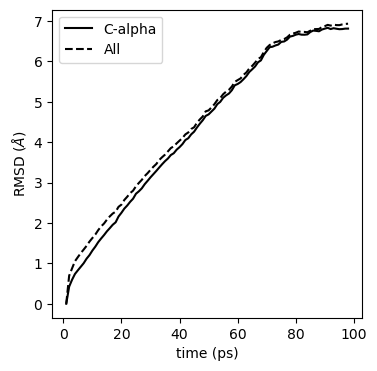

In [48]:
import matplotlib.pyplot as plt
rmsd = R.rmsd.T   # transpose makes it easier for plotting
time = rmsd[1]
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.plot(time, rmsd[2], 'k-',  label="C-alpha")
ax.plot(time, rmsd[3], 'k--', label="All")
# ax.plot(time, rmsd[4], 'r--', label="LID")
# ax.plot(time, rmsd[5], 'b--', label="NMP")
ax.legend(loc="best")
ax.set_xlabel("time (ps)")
ax.set_ylabel(r"RMSD ($\AA$)")

In [1]:
from utils.traj_process import *
import nglview as nv

psf = "./tmp/step3_input.psf"
xtc = "./tmp/prod_step_5.xtc"

In [2]:
u = mda.Universe(psf, xtc)


In [3]:
view = nv.show_mdanalysis(u)
view.add_representation('point', 'RESNAME TIP3')
view.center()
view

NGLWidget(max_frame=20000)

In [6]:
def extract_pro(psf, xtc, out_psf, out_xtc):

    u = mda.Universe(psf, xtc)
    protein = u.select_atoms('protein')
    protein_psf = protein.convert_to("PARMED")
    protein_psf.save(out_psf)
    
    with mda.Writer(out_xtc, protein.n_atoms) as W:
        for ts in u.trajectory:
            W.write(protein)
                
    return None 


In [8]:
extract_pro(psf, xtc, "./tmp/test.psf", "./tmp/test_protein.xtc")

In [12]:
u2 = mda.Universe("./tmp/test.psf", "./tmp/test_protein.xtc")
view = nv.show_mdanalysis(u2)
view.add_representation('point', 'RESNAME TIP3')
view.center()
view

NGLWidget(max_frame=20000)

In [10]:
traj_align_onfly("./tmp/test.psf", "./tmp/test_protein.xtc", "./tmp/aligned.xtc")

In [11]:
u3 = mda.Universe("./tmp/test.psf", "./tmp/aligned.xtc")
view = nv.show_mdanalysis(u3)
view.add_representation('point', 'RESNAME TIP3')
view.center()
view

NGLWidget(max_frame=20000)

In [13]:
u3.select_atoms("")

<AtomGroup with 855 atoms>